# Single physics tutorial
In this tutorial we visit how to run single physics simulations in PorePy. 
We will here solve a single phase flow problem, which is done by first covering incompressible flow.
This part includes modifying the domain, boundary conditions, and source terms. 
Towards the end of the tutorial we will modify the fluid parameters to solve the compressible flow problem.

## Models in PorePy
A model in porepy is defined by a combination of Python classes, where each class covers its own aspect of the model.
These aspects are

* Geometry
* Equations
* Variables
* Constitutive laws
* Boundary conditions
* Solution strategy

and they are combined using multiple inheritance in Python.
Since the model classes are composed with relatively advanced use of Python inheritance and mixin, the (intermediate to) advanced user is highly encouraged to familiarize themselves with those concepts.
We will not visit the technicalities about this, so we refer to [this blog post](https://www.thedigitalcatonline.com/blog/2020/03/27/mixin-classes-in-python/) for an introduction on the topic.

In PorePy, all class types except solution strategies are treated as Mixins.

Porepy provides complete models for several problems, and they are fully capable for running a simulation as they are. 
The user might be interested in modifying the model setup, and this is what we will cover in this tutorial.
The usual way of doing this is by overriding the pre-defined, default methods.

## Incompressible flow
As there already exists a model for the single phase flow problem in PorePy, running a simulation is possible with only a few lines of code.
The model can be found in the fluid_mass_balance.py file under the name ``SinglePhaseFlow``.

We start off by importing the necessary packages:

In [61]:
import porepy as pp
import numpy as np

### Geometry
The default geometry is only a unitary domain without any fractures, and we will therefore look at how to modify it. 
Here we will demonstrate how this is done by overriding methods found within the ``set_geometry`` method found in ``pp.ModelGeometry``. 
This is where the geometry related methods and information are located.

More specifically, we will override the following methods:

* ``set_domain``
* ``set_fractures``
* ``grid_type``
* ``meshing_arguments`` 

A more detailed introduction of initializing geometry can be found in the [grid structure](./grid_structure.ipynb) tutorial and the [meshing of fractures](./meshing_of_fractures.ipynb) tutorial. Below we demonstrate an example of how to replace the default geometry with one that contains a diagonal fracture. 

In [62]:
from porepy.applications.md_grids.domains import nd_cube_domain

class ModifiedGeometry:
    def set_domain(self) -> None:
        """Defining a two-dimensional square domain with sidelength 2."""
        size = 2/self.units.m
        self._domain = nd_cube_domain(2, size)
    
    def set_fractures(self) -> None:
        """Setting a diagonal fracture"""
        frac_1 = pp.LineFracture(np.array([[0.2, 1.8], [0.2, 1.8]]))
        self._fractures = [frac_1]

    def grid_type(self) -> str:
        """Choosing the grid type for our domain.

        As we have a diagonal fracture we cannot use a cartesian grid. Cartesian grid is the default provided, and we therefore override this method to assign simplex instead.

        """
        return self.params.get("grid_type", "simplex")

    def meshing_arguments(self) -> dict:
        """Meshing arguments for md-grid creation. 
        
        Here we determine the cell size.

        """
        mesh_args: dict[str, float] = {"cell_size": 0.25 / self.units.m}
        return mesh_args

To make a new model with the modified geometry, we simply combine ``ModifiedGeometry`` with the standard model using multiple inheritance. 

Note that the modified geometry is listed _before_ the default model when creating the new one.
As a general rule, if you're overriding functionality using a mixin class, you must always list it before the model that defines the default behaviour. 
Overwise, it will not work.
The reason why is because of something called "Method Resolution Order" (MRO), and an explanation of this is presented in the link that is provided in the beginning of the tutorial. 

In [63]:
class SinglePhaseFlowGeometry(
    ModifiedGeometry,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

We will run the simulation by using the PorePy method ``run_time_dependent_model`` which calls the ``Model`` methods ``prepare_simulation`` and ``after_simulation``. 
A user interested in the inner workings of this is advised to inspect these methods and possibly the submethods called therein. 
After running the simulation we make a call to ``plot_grid`` to visualize the solution:

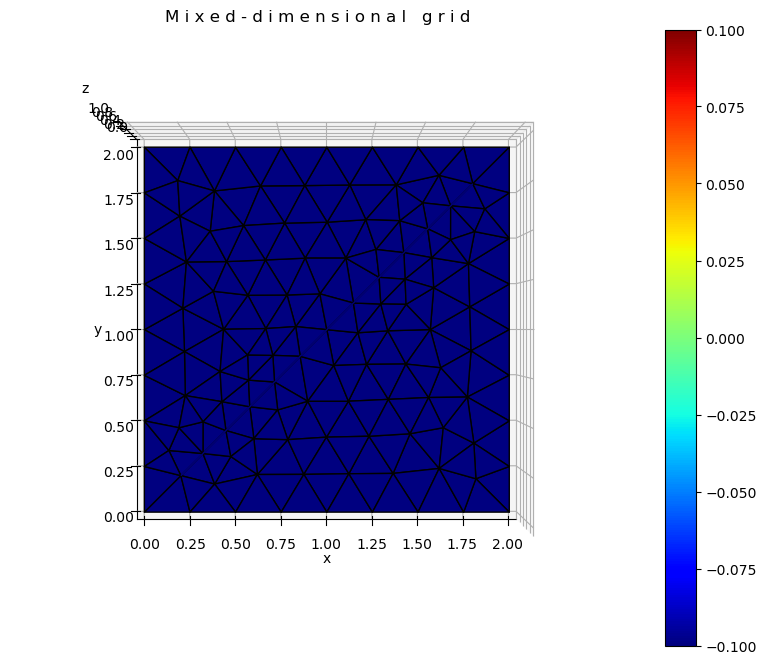

In [64]:
params = {}
model = SinglePhaseFlowGeometry(params)  
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8))

The empty `params` implies that unitary/zero default values are used for all constants.
Similarly, the default source term and boundary conditions are zero, resulting in an absence of driving forces. 
This provides us with the constant solution shown in the figure above.

### Boundary conditions, fluid and solid constants
One example of how to include some driving forces is by defining some non-zero boundary conditions. 
This is done similarly to how we modified the geometry, meaning that we will now define a mixin for the boundary conditions. 
Methods for the boundary conditions are already present in the default model class, so modifying them can be done by overwriting the methods ``bc_type_darcy`` and ``bc_values_darcy``.

In [65]:
class ModifiedBC:
    def bc_type_darcy(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_darcy(self, subdomains: list[pp.Grid]):
        """Zero bc value on top and bottom, 5 on west side, 2 on east side."""
        # Define boundary regions
        values = []
        for sd in subdomains:
            _, east, west, _, _, _, _ = self.domain_boundary_sides(sd)
            val_loc = np.zeros(sd.num_faces)
            # See section on scaling for explanation of the conversion.
            val_loc[west] = self.fluid.convert_units(5, "Pa")
            val_loc[east] = self.fluid.convert_units(2, "Pa")
            values.append(val_loc)
        return pp.wrap_as_ad_array(np.hstack(values), name="bc_values_darcy")

To combine the standard model with the new geometry _and_ the boundary conditions, we simply create a new class which inherits from all of them:

In [66]:
class SinglePhaseFlowGeometryBC(
    ModifiedGeometry,
    ModifiedBC,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

Before we go ahead and run the model, we will also have a look at how to change parameters present in the model.
Material constants are stored in and accessed through `SolidConstants` and `FluidConstants` objects.
Instantiating these classes is how we can make adjustments of the material constants. 

This is done by creating ``fluid`` and ``solid`` dictionaries inside the ``material_constants`` dictionary, which is again located within the ``params`` dictionary.
An example is shown below.

In [67]:
fluid_constants = pp.FluidConstants({"viscosity": 0.1, "density": 0.2})
solid_constants = pp.SolidConstants({"permeability": 0.5, "porosity": 0.25})
material_constants = {"fluid": fluid_constants, "solid": solid_constants}
params = {"material_constants": material_constants}


Once the fluid and solid constants are defined within the ``params`` dictionary, we feed them to the model, and then run the simulation.

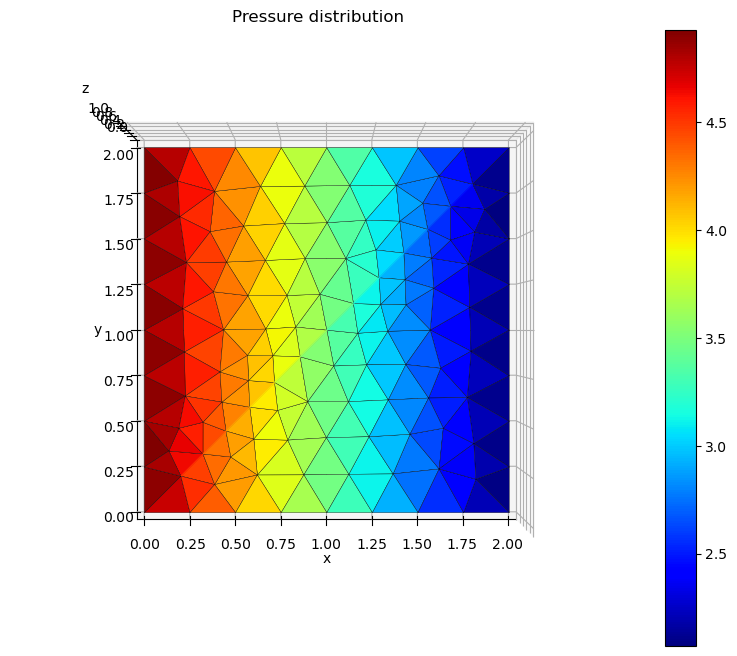

In [68]:
model = SinglePhaseFlowGeometryBC(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.25, title="Pressure distribution")

#### Fracture source
Another way to modify the model is to include a fracture source.
Below we demonstrate how a unitary fracture source can be included by a rather simple modification to the method governing the fluid source

In [69]:
class ModifiedSource:
    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign unitary fracture source"""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []

        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells))

        external_sources = pp.wrap_as_ad_array(np.hstack(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

For the sake of seeing the effects of the unitary fracture source, we do not include the non-zero boundary conditions.
This is simply done by not inheriting from ``ModifiedBC`` when creating the new model with a fracture source.

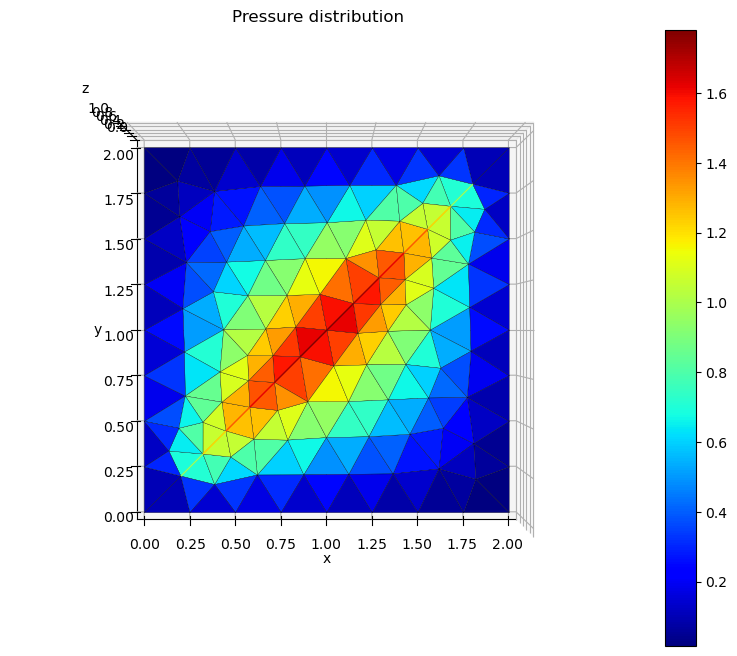

In [70]:
class SinglePhaseFlowTutorial(
    ModifiedGeometry,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow):
    ...

model = SinglePhaseFlowTutorial(params)
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2, title="Pressure distribution")

## Compressible flow
Building upon the model with a unitary fracture source and zero boundary conditions, we will now consider a compressible fluid.


In [71]:
class SlightlyCompressibleFlow(
    ModifiedGeometry,
    ModifiedBC,
    ModifiedSource,
    pp.fluid_mass_balance.SinglePhaseFlow
):
    ...


Setting the compressibility to a non-zero value makes the fluid compressible, and this makes the model time-dependent. 
For seeing the gradual evolution of the solution we also need to assign non-default values to the ``pp.TimeManager``. 

In other words, all previous simulations are only run with one time step as this is the default time step amount.
Simulations with multiple time steps requires users to explicitly define parameters such as time step size and the time schedule.
The time manager, with the new, non-default time parameters, is passed to the model through the ``params`` dictionary.

In [72]:
fluid_constants = pp.FluidConstants({"compressibility": 0.01})
material_constants = {"fluid": fluid_constants}

time_manager = pp.TimeManager(
    schedule=[0, 1e-3],
    dt_init=1e-4,
    constant_dt=True,
    iter_max=10,
    print_info=True,
)

params = {"material_constants": material_constants, "time_manager": time_manager}
model = SlightlyCompressibleFlow(params)

Running the model and doing a simple visualization of the result is done in the exact same way as before:

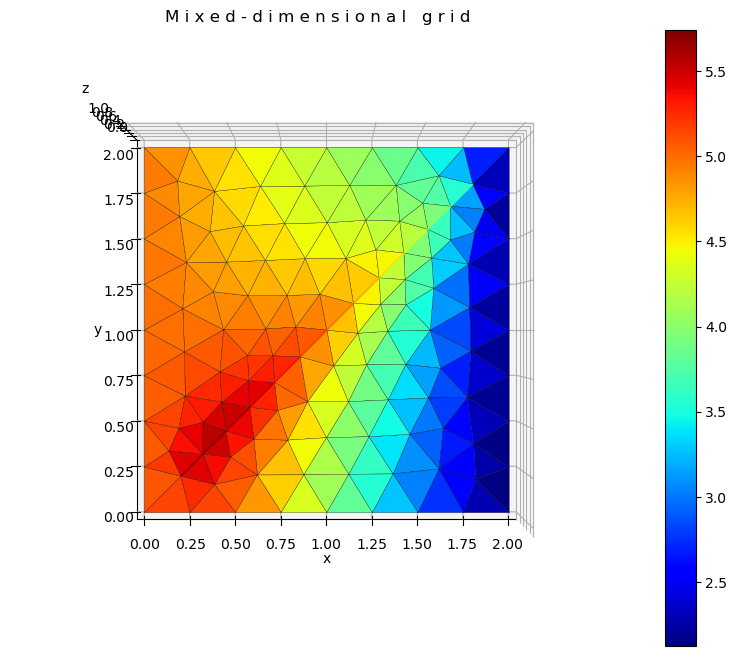

In [73]:
pp.run_time_dependent_model(model, params)
pp.plot_grid(model.mdg, "pressure", figsize=(10, 8), linewidth=0.2)

The figure above shows the end solution, while the gradual evolvement of it can be visualized using e.g. ParaView.
Files for visualizing are by default saved in a folder named visualization in the working directory, see the exporter tutorial for details. TODO: add reference here


# What have we done
We have had a look at how single physics simulations can be run with PorePy by modifying various different parts of the default models.

Specifically, we modified the following:
* Model geometry
* Boundary conditions
* Source term
* Material constants
* Time manager